In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import ShuffleSplit,train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler

In [ ]:
'''
輸入資料
'''
import pandas as pd
from scipy.io import arff

dataset = pd.read_csv('/content/german.data')

'''
欄位前處理
'''
dataset = dataset[dataset.columns[0]].str.split(' ',expand=True)

'''
更換欄位名稱
'''
dataset.columns = ['ExistingCheckingAccount', 'Duration_month', 'CreditHistory', 'Purpose', 'CreditAmount',
         'SavingsAccount', 'EmploymentSince', 'InstallmentRate_DisposableIncome', 'StatusAndSex', 'OtherDebtors',
         'ResidenceSince', 'Property', 'Age_year', 'OtherInstallmentPlans', 'Housing',
         'ExistingCredits', 'Job', 'PeopleLiable', 'Telephone', 'ForeignWorker', 'Classification']

numAttribute = ['ExistingCheckingAccount', 'CreditHistory', 'Purpose', 'SavingsAccount', 'EmploymentSince',
           'StatusAndSex', 'OtherDebtors', 'Property', 'OtherInstallmentPlans', 'Housing', 'Job',
           'Telephone', 'ForeignWorker']
qualiAttribute = ['CreditAmount', 'Duration_month', 'InstallmentRate_DisposableIncome', 'ResidenceSince', 'Age_year',
           'ExistingCredits', 'PeopleLiable', 'Classification']

for j in range(len(qualiAttribute)):
    dataset[qualiAttribute[j]] = pd.to_numeric(dataset[qualiAttribute[j]])
print(dataset.head())

'''
Label encoding編碼
'''
from sklearn.preprocessing import LabelEncoder

dataset_origin = dataset
print(dataset_origin.head())

labelencoder = LabelEncoder()
for i in range(len(numAttribute)):
    print('before: ', numAttribute[i],": ", dataset_origin[numAttribute[i]].unique())
    dataset[numAttribute[i]] = labelencoder.fit_transform(dataset[numAttribute[i]])
    print('afer: ', numAttribute[i],": ", dataset[numAttribute[i]].unique())
print(dataset.head())

dataset.Classification.replace([1,2], [1,0], inplace=True)

dataset_train = dataset[:900]
dataset_test= dataset[900:]

  ExistingCheckingAccount  Duration_month CreditHistory Purpose  CreditAmount  \
0                     A12              48           A32     A43          5951   
1                     A14              12           A34     A46          2096   
2                     A11              42           A32     A42          7882   
3                     A11              24           A33     A40          4870   
4                     A14              36           A32     A46          9055   

  SavingsAccount EmploymentSince  InstallmentRate_DisposableIncome  \
0            A61             A73                                 2   
1            A61             A74                                 2   
2            A61             A74                                 2   
3            A61             A73                                 3   
4            A65             A73                                 2   

  StatusAndSex OtherDebtors  ...  Property Age_year  OtherInstallmentPlans  \
0          A92

In [ ]:
from imblearn.over_sampling import SMOTE

X = dataset_train.drop('Classification', axis=1)
y = dataset_train['Classification']

X_test = dataset_test.drop('Classification', axis=1)
y_test = dataset_test['Classification']

#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

# Apply SMOTE

#sm = BorderlineSMOTE(sampling_strategy='minority')
sm = SMOTE(sampling_strategy='minority')
X_train_s, y_train_s = sm.fit_resample(X, y)

print("Before/After clean")
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_s, return_counts=True)
print(dict(zip(unique, counts)))

Before/After clean
{0: 269, 1: 631}
{0: 631, 1: 631}


In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import KFold

print(' with grid search')
# play with these params
params={
    'max_depth': [3, 5, 7, 9],
    'min_child_weight':range(1,6,2),
    'eta':[0.05,0.1,0.15,0.2],
    'gamma':[i/10.0 for i in range(0,5)]
}

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

xgb_clf = xgb.XGBClassifier()

rs = GridSearchCV(xgb_clf,
                  params,
                  cv=kfold,
                  scoring="roc_auc",
                  verbose=False)

rs.fit(X_train_s, y_train_s)


print("最佳参数组合：", rs.best_params_)
print("最佳模型得分：", -rs.best_score_)

best_model =  rs.best_estimator_

# 測試
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:,1] #model.best_iteration

print ('\n')
print ("Model Final Generalization roc_auc_score: %.6f" %roc_auc_score(y_test,y_pred_proba))
print ("Model Final Generalization ACC: %.6f" %accuracy_score(y_test,y_pred))
print ("Model Final Generalization F1: %.6f" %f1_score(y_test,y_pred))
print ("Model Final Generalization precision: %.6f" %precision_score(y_test,y_pred))
print ("Model Final Generalization recall: %.6f" %recall_score(y_test,y_pred))

np.save('/content/y_test_s.npy', y_test)
np.save('/content/y_pred_proba_s.npy', y_pred_proba)

 with grid search
最佳参数组合： {'eta': 0.15, 'gamma': 0.2, 'max_depth': 9, 'min_child_weight': 3}
最佳模型得分： -0.9129852132291271


Model Final Generalization roc_auc_score: 0.773245
Model Final Generalization ACC: 0.737374
Model Final Generalization F1: 0.805970
Model Final Generalization precision: 0.818182
Model Final Generalization recall: 0.794118


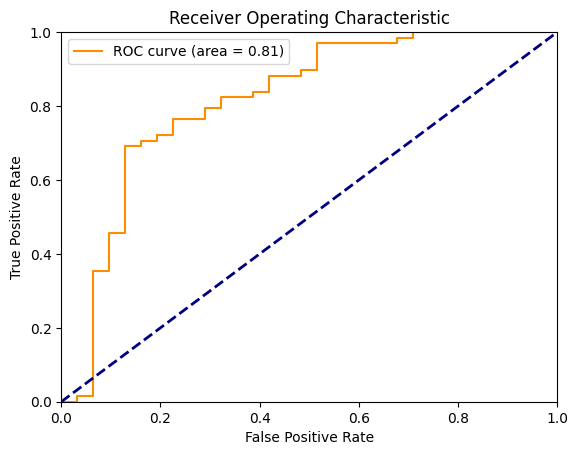



Accuracy score of the model 0.7777777777777778
Classification report 

              precision    recall  f1-score   support

           0       0.64      0.68      0.66        31
           1       0.85      0.82      0.84        68

    accuracy                           0.78        99
   macro avg       0.74      0.75      0.75        99
weighted avg       0.78      0.78      0.78        99



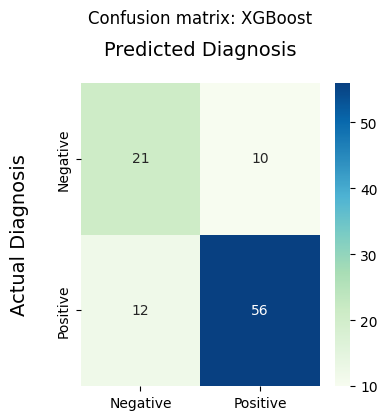

In [ ]:
import seaborn as sns

# Function to get roc curve
def get_roc (y_test,y_pred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="upper left")
    plt.show()
    return

def model_performance(y_test,y_pred, method):

    # calculate the accruacy of the model
    print("Accuracy score of the model", accuracy_score(y_test,y_pred))
    print("Classification report \n")

    #generate the classification report
    print(classification_report(y_test,y_pred))

    #generate the confusion matrix
    fig = plt.figure(figsize = (4,4))
    ax = fig.gca()
    cnf_matrix_log = confusion_matrix(y_test, y_pred)
    sns.heatmap(pd.DataFrame(cnf_matrix_log), annot=True,cmap="GnBu" , fmt='g')
    ax.xaxis.set_label_position("top")
    ax.xaxis.set_ticklabels(['Negative', 'Positive'])
    ax.yaxis.set_ticklabels(['Negative', 'Positive'])
    ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
    ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
    plt.tight_layout()
    plt.title('Confusion matrix: '+  method + '\n', y=1.1)

get_roc (y_test,y_pred_proba)
print('\n')
model_performance(y_test,y_pred, 'XGBoost')